#Part 1. Comparing Full Chef to Linear Dynamics - Influence on the Invariants

This is the first part in a series of notebooks investigating the effect of larger particle amplitudes on the single particle invariants.

####Motivation
It would seem that the invariant is less well preserved when bunches which larger amplitudes are injected into the IOTA lattice. Based on a quick discussion with David and Stephen, there are a few options.

1. One possibility is that the nonlinear components of the quadrupoles and dipoles are influencing the particle trajectories, given that the ring is small, and having a stronger influence on the invariants. **To test this, I will run the lattice using only linear dynamics in the ring (outside of the NL magnet).**

2. Another possibility is that the nonlinear magnet is being well reprsented in synergia, and that at large amplitudes there are variations in the field which are mucking up the particle trajectories. **To test this, I will construct the IOTA magnet with more slices (using the madx script).**


####Execution
**For this notebook, we will only consider #1.** The basis for these tests will be the `lattice_1IO_nll_center.madx` lattice. I will use a matched bunch which generalized emittance of approximately 10 mm-mrad, and I will run for ~100 turns with 1000 macro particles.

In [2]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [3]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 17/08/2015 

CPython 2.7.10
IPython 3.1.0


In [4]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

In [67]:
lattice = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_nll_center.madx")
lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_center.madx")


for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
        
nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = '10_NLL_Matched_Partial_Linear'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=1000
#opts.emitx = 1.0e-5
#workflow.make_path(outputdir)


stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
lattice_simulator2 = stepper2.get_lattice_simulator()

Construct the matched bunch with generalized emittance 10 mm-mrad.

In [8]:
opts.emit_transverse = 1.e-5
EllipticBeam6D.EllipticalBeam6D(opts)

ref = lattice.get_reference_particle()
#read in the file and construct a synergia bunch
particles_file = 'myBunch.txt'
comm = synergia.utils.Commxx(True)
bucket_length = 0.05 #workaround
myBunch = read_bunch.read_bunch(particles_file, ref, opts.real_particles, bucket_length, comm, verbose=False)

original_particles = np.copy(myBunch.get_local_particles())

 !Warning -- 
File myBunch.txt already exists. Renaming the old file to myBunch.txt1439832753
Loading Synergia particles from txt file:  myBunch.txt


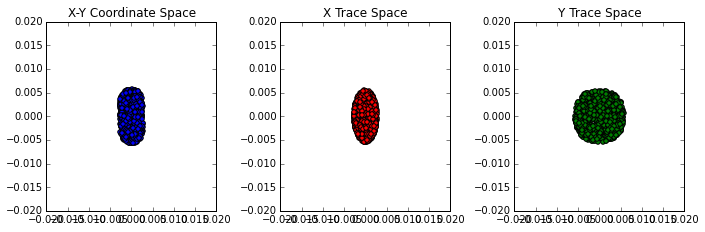

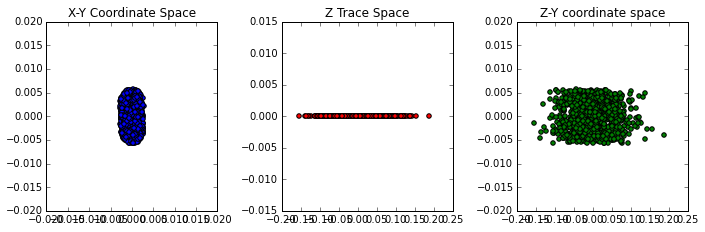

In [9]:
from base_diagnostics import pltbunch
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [10]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [11]:
#~0.3s per turn with 1000 macro particles and full chef only in the NL magnet
opts.turns = 100
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

###Diagnostics

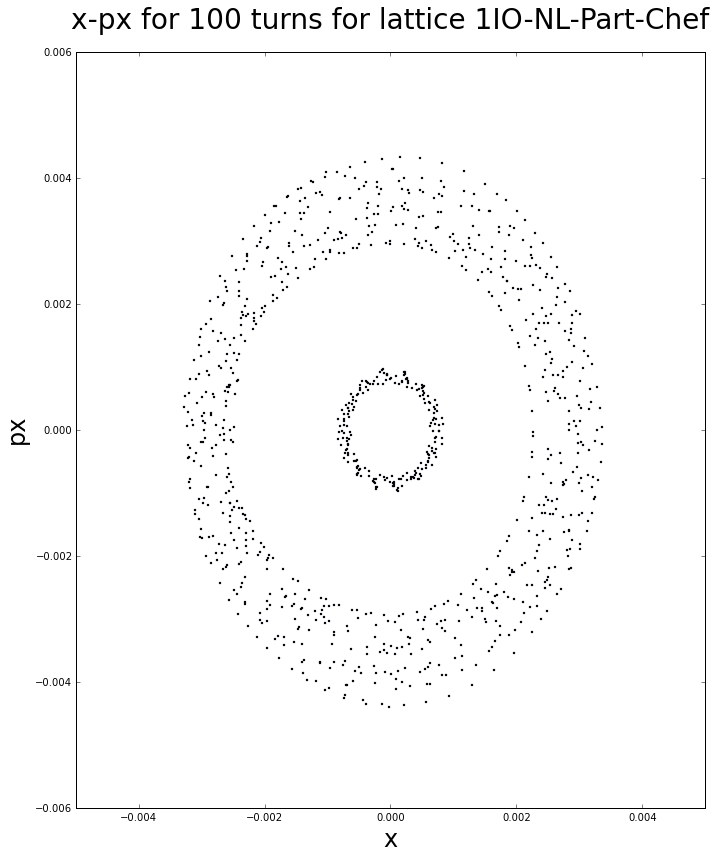

In [69]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-NL-Part-Chef'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['x','px']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

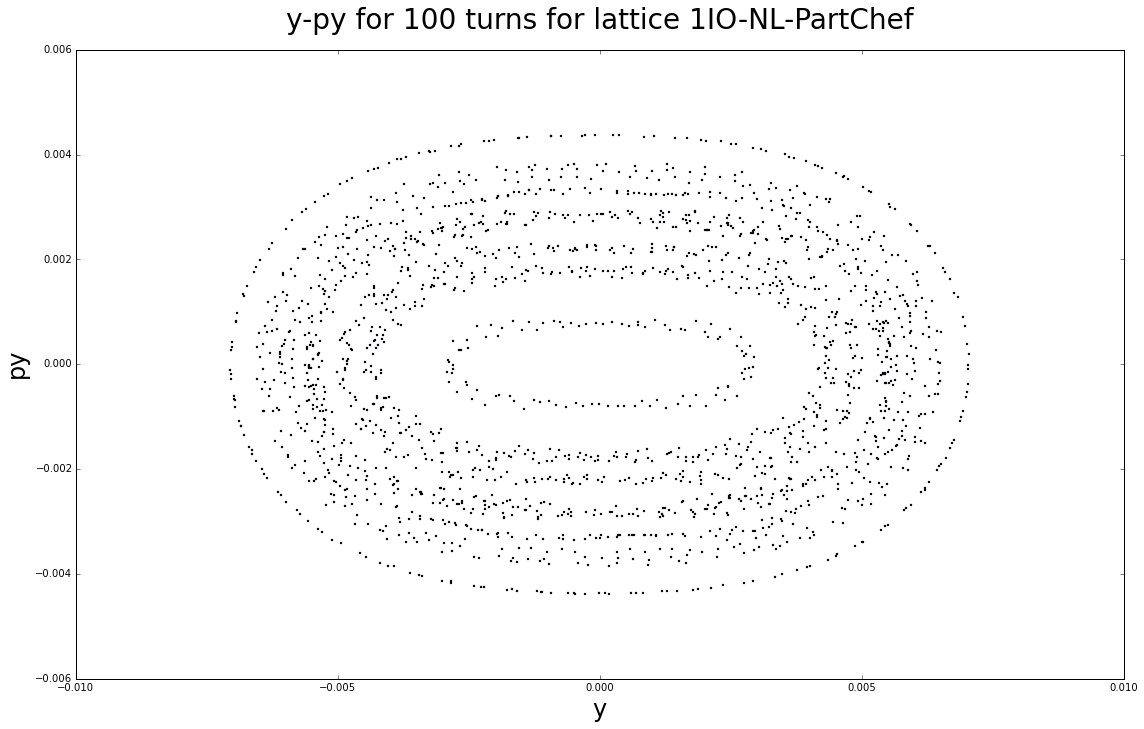

In [70]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-NL-PartChef'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['y','py']
popts.num = 20
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

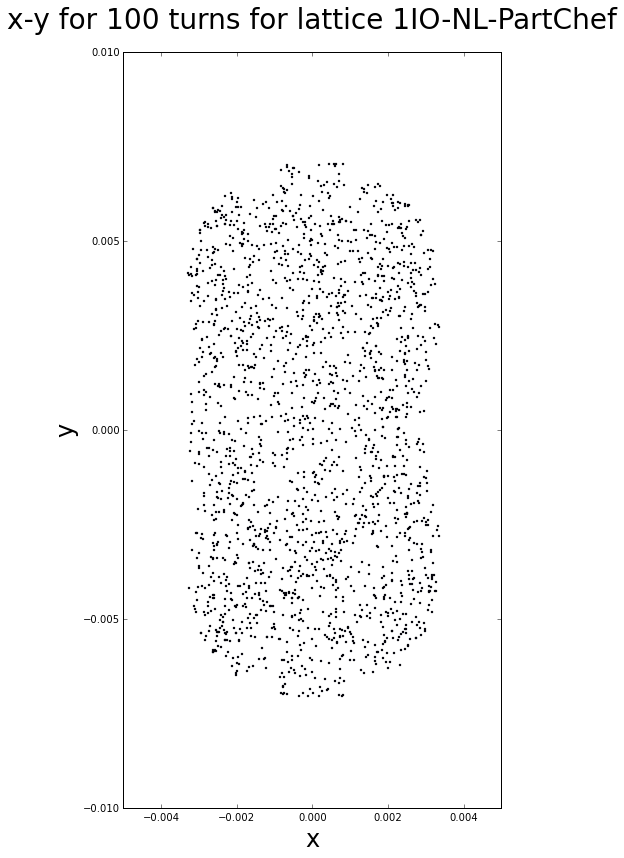

In [75]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-NL-PartChef'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['x','y']
popts.num = 20
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

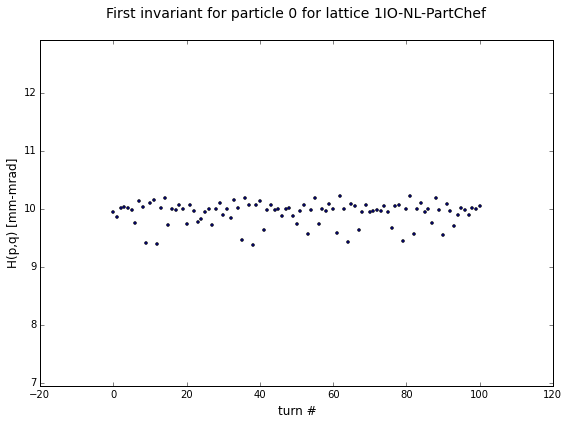

In [72]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 1
popts.ID = 0
popts.variance = .3
popts.save = False
singleparticle.plot_elliptic_Invariant(popts)
#singleparticle.plot_H_I(popts)

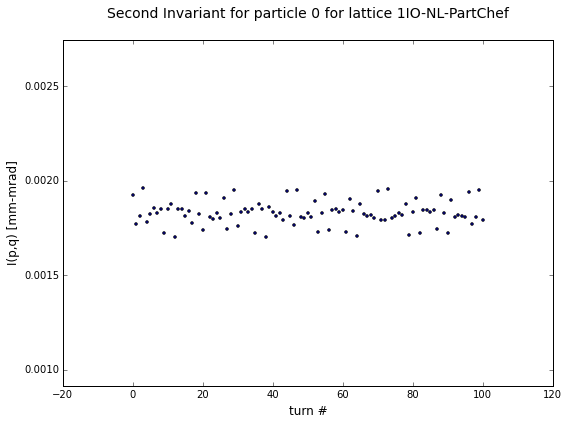

In [73]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 2
popts.ID = 0
popts.variance = .5
popts.save = False
singleparticle.plot_elliptic_Invariant(popts)
#singleparticle.plot_H_I(popts)

In [74]:
popts.macro_particles = opts.macro_particles
popts.ID = 5
hArray = singleparticle.calc_elliptic_Invariant(popts)
singleparticle.stats_Invariant(hArray,popts)

H -  Mean: 10.0598948964 [mm-mrad] std (%): 1.58673892038
I -  Mean: 0.00256651319784 [mm-mrad] std (%): 2.16856625716


In [28]:
stats = spi.gather_stats(hArray,opts.macro_particles)  

In [49]:
from elliptic import spi
popts.printfile = 'stats.txt'
spi.print_stats(hArray,popts)

Summary of invariants for 1000 particles with lattice 1IO-NL-PartChef
H [mm-mrad]: 9.87082221505
H_std [%]: 2.4325914545
I [mm-mrad]: 0.00172761867846
I_std [%]: 3.10196662244


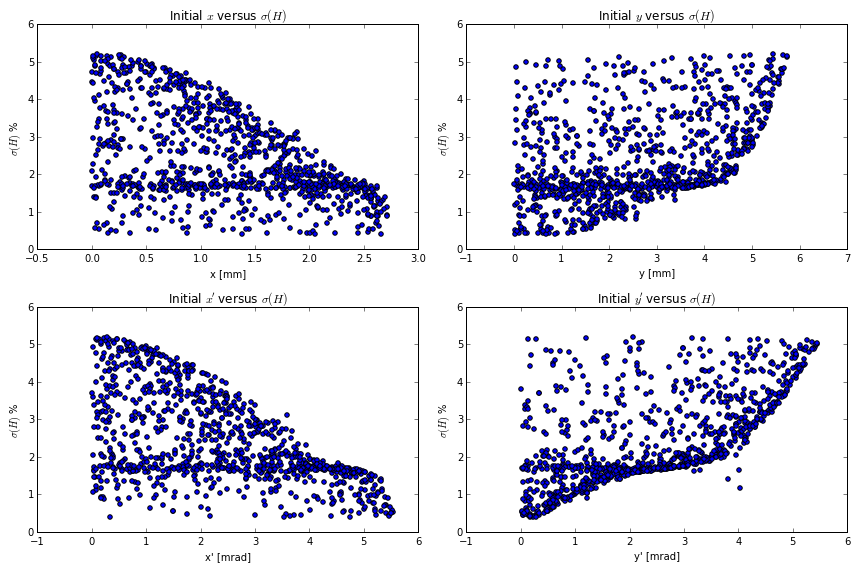

In [54]:
popts.num = 1
spi.plot_amplitudes(hArray,original_particles,popts)

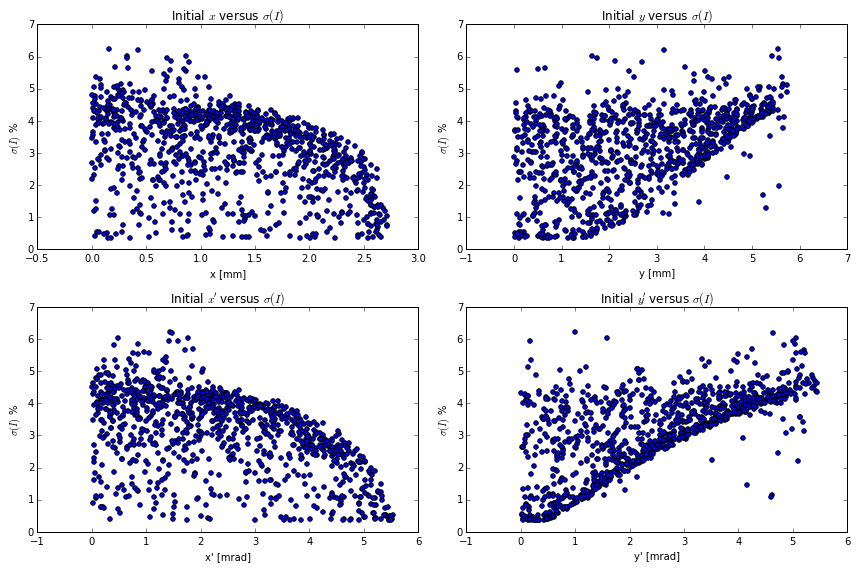

In [55]:
popts.num = 2
spi.plot_amplitudes(hArray,original_particles,popts)

It's clear that the variation is considerably smaller when linear dynamics are specified for the remainder of the lattice, particularly for the 2nd Invariant. Nonetheless, it remains the case that the invariants are sensitive to large initial amplitudes in `y` and `y'` (or correspondingly small amplitudes in `x` and `x'`).

The next step is to consider slicing the nonlinear magnet into further segments to smooth out the magnetic field. This will take place in part 2.